In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(7395, 23)
(7395, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
        0.00000000e+00,  0.00000000e+00, -7.23774556e-04,  1.63913405e-02,
       -4.25253900e-03,  2.52678370e-01,  1.34278938e-01, -2.77884607e-01,
        2.48699126e-01, -1.23663102e-01, -3.13305709e-01, -2.69007467e-01,
        1.27140112e-01, -3.13660563e-01, -2.69880417e-01, -1.35002353e-01,
       -2.81540030e-01,  0.00000000e+00,  1.00000000e+00])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.03600915, -0.00539881,  0.03108886,  0.01310269])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 9:11], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 12:14], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 15:17], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 18:20])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9916888225114675
RMSE:  0.014580034711110508
The lowest error is:  9.44540618747769e-05
The highest error is:  0.0420818224261279
The avg. error is:  0.011108676696991598


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 0.29510716,  0.29478174,  0.01960601, -0.00458688, -0.45638574,
        -0.91266732, -0.75873582,  0.37751051,  0.57221144, -0.72549206,
         0.5429374 ]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([0.10270669])

Text(0, 0.5, 'Predictions')

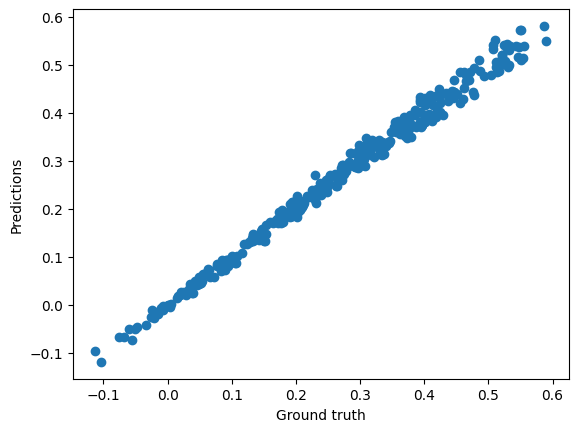

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 9:11], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 12:14], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 15:17], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 18:20])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9307950067322396
RMSE:  0.004352468576901624
The lowest error is:  3.618652427457743e-05
The highest error is:  0.011833824733459286
The avg. error is:  0.0034276593432502485


In [17]:
model_fr_relative_swinging_y.coef_

array([[-0.070196  ,  0.04971317,  0.08501642,  0.50302601,  0.11973512,
        -0.12532096, -1.11274679,  0.14053705,  0.15554353, -0.68394901,
         0.45047802]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([-0.36268649])

Text(0, 0.5, 'Predictions')

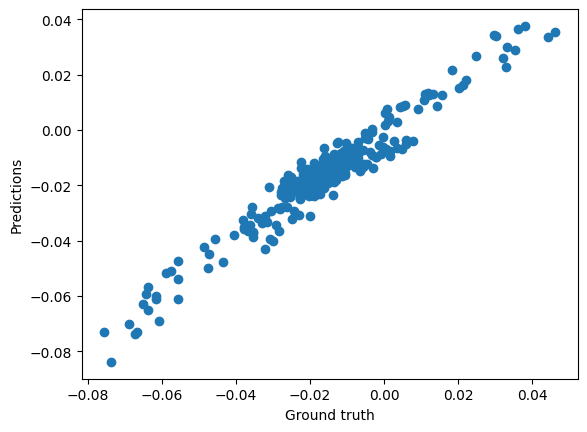

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')